## Infer causal Structure on ScanPy Data

#### Structure:
A: Preparation
1. Load Data & Initial scanpy operations
2. Practical data Annotation
3. Filter & Normalize Data as needed

B: Algorithms
1. GRNBoost2
2. GIES

Dependencies:
 use a conda-env with:
 - scanpy python-igraph leidenalg

 GRNBoost:
 - conda install -c bioconda arboreto
 
 GIES:
 - pip install gies

In [21]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

import scp_infer as scpi

In [22]:
results_file = './data/write/Schraivogel_chr8_ad-scaled_10gene.h5ad'  # the file that will store the analysis results

# A. Preparation
## 1. Load Data & Initial scanpy operations

1. Get Data Ready
- load the dataset
- do relevant configuration
    - trim Dataset to reduce computational complexity
    - filter for quality (if necessary)

In [23]:
#Loading the dataset-file using scanPy

filename = "./data/SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_8_screen.h5ad"
adata = sc.read(filename)                     
adata
print("Data type: ", type(adata.X))

/home/jans/miniconda3/envs/py-infer/lib/python3.12/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


Data type:  <class 'scipy.sparse._csr.csr_matrix'>


In [24]:
# Visulaizing the data
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

sc.pp.filter_cells(adata, min_genes=50)
sc.pp.filter_genes(adata, min_cells=3)

adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

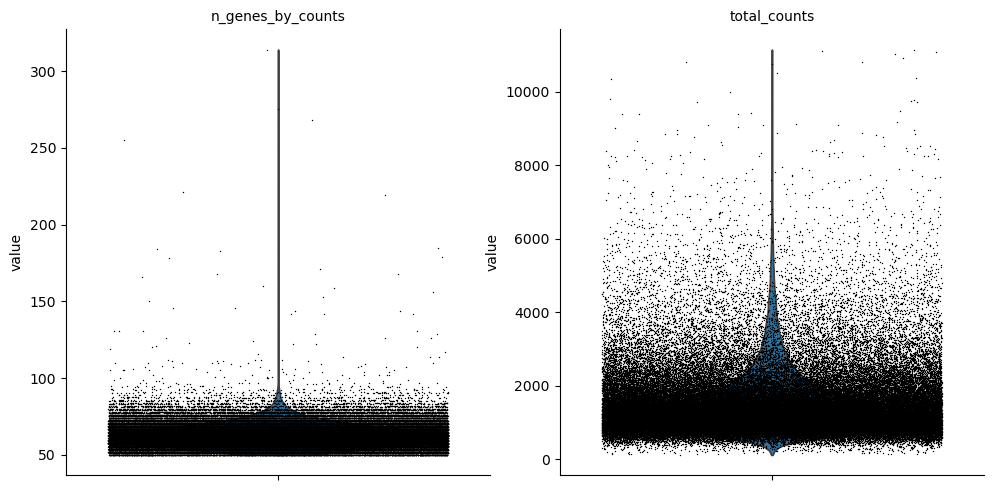

In [25]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts','pct_counts_mt'],
             jitter=0.4, multi_panel=True)


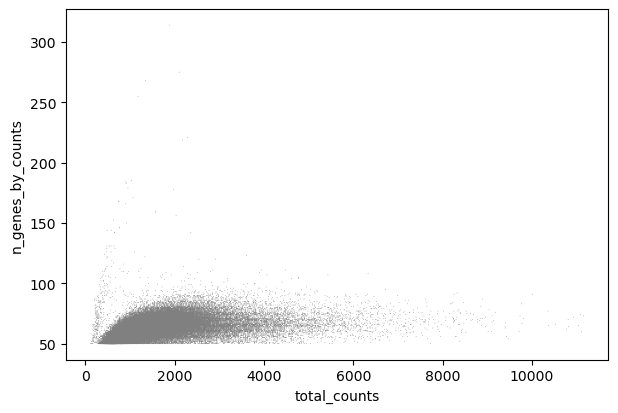

In [26]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [27]:
#1st step: extract data matrix, gene names and cell names from the AnnData object
gene_names = adata.var_names
cell_names = adata.obs_names

#print("Data matrix shape: ", df.shape)
#print("sample: ", df.iloc[0:3,0:3])
print(len(gene_names),"genes: ", [i for i in gene_names[:3]])
print(len(cell_names),"cells: ", [i for i in cell_names[:1]])

#2nd step: extract metadata from the AnnData object and exctract perturbation information
metadata = adata.obs
metadata.head()

# Look at more perturbation labels
# print(adata.obs['perturbation'].astype(str).copy()[1000:1020])

4191 genes:  ['ANGPT1', 'ANKRD46', 'ASAP1']
103160 cells:  ['TGATTGACAAACCTGAGAGCTATA-sample_14']


,replicate,tissue_type,cell_line,cancer,disease,celltype,organism,perturbation,perturbation_type,ncounts,ngenes,percent_mito,percent_ribo,nperts,n_genes_by_counts,total_counts,n_genes,total_counts_mt,pct_counts_mt
cell_barcode,,,,,,,,,,,,,,,,,,,
TGATTGACAAACCTGAGAGCTATA-sample_14,sample_14,cell_line,K562,True,chronic myelogenous leukemia,lymphoblasts,human,RIPK2_+_90770127.23-P1P2,CRISPR,1247.0,61,0.0,7.618284,3,61,1247.0,61,0.0,0.0
TGATTGACAAACCTGAGGTGACCA-sample_14,sample_14,cell_line,K562,True,chronic myelogenous leukemia,lymphoblasts,human,multiplet,CRISPR,1977.0,77,0.0,6.120384,1,77,1977.0,77,0.0,0.0
TGATTGACAAACCTGAGGTGCTTT-sample_14,sample_14,cell_line,K562,True,chronic myelogenous leukemia,lymphoblasts,human,multiplet,CRISPR,2331.0,79,0.0,8.494208,1,79,2331.0,79,0.0,0.0
TGATTGACAAACCTGAGTCGAGTG-sample_14,sample_14,cell_line,K562,True,chronic myelogenous leukemia,lymphoblasts,human,DSCC1_-_120868119.23-P1P2,CRISPR,2615.0,65,0.0,6.462715,3,65,2615.0,65,0.0,0.0
TGATTGACAAACCTGCAACTTGAC-sample_14,sample_14,cell_line,K562,True,chronic myelogenous leukemia,lymphoblasts,human,OXR1_+_107670106.23,CRISPR,1445.0,63,0.0,9.757786,3,63,1445.0,63,0.0,0.0


## 2. Practical data Annotation

In [28]:
#3rd step: extract perturbation information and save it in the observation metadata

adata = scpi.adata.get_perturb_labels(adata)

# Check the assignment of perturbation labels for a few cells
print("")
print("Cell Nr. & Perturbation labels: ")
print("Non-targeting: ",           np.array(list(zip(np.arange(len(cell_names))[:100],adata.obs['perturbation'])))[adata.obs['non-targeting'][:100]][:2])
print("Multiplet index: ",         np.array(list(zip(np.arange(len(cell_names))[:100],adata.obs['perturbation'])))[adata.obs['multiplet'][:100]][:2])
print("Gene perturbation index: ", np.array(list(zip(np.arange(len(cell_names))[:100],adata.obs['perturbation'])))[adata.obs['gene_pert'][:100]][:2])

Non-targeting: 1717 Multiplet: 19392 Normal pert.: 82051
Filtered 80130 un-identifiable perturbations:  1921 filtered perturbations

Cell Nr. & Perturbation labels: 
Non-targeting:  [['5' 'non-targeting']
 ['10' 'non-targeting']]
Multiplet index:  [['1' 'multiplet']
 ['2' 'multiplet']]
Gene perturbation index:  [['0' 'RIPK2']
 ['3' 'DSCC1']]


/home/jans/Documents/Masterarbeit/code/master-thesis/scanpy_infer/filter_adata.py:34: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  gene_pert_f = gene_in_var & adata_obj.obs['gene_pert']


In [29]:
print(adata.obs['perturbation'])
# Take a closer look at the perturbed genes
adata.var['gene_perturbed'] = adata.var_names.isin(adata.obs['perturbation'][adata.obs['gene_pert']])

print("Nr. Perturbed genes: ", adata.var['gene_perturbed'].sum())
print("Perturbed genes: ", adata.var_names[adata.var['gene_perturbed']][0:15])

Nr. Perturbed genes:  10
Perturbed genes:  Index(['CCNE2', 'CPQ', 'DSCC1', 'FAM83A', 'LRRCC1', 'OXR1', 'PHF20L1', 'RIPK2',
       'STK3', 'UBR5'],
      dtype='object', name='gene_symbol')


## 3. Filter & Normalize Data as needed

look at how sparse the data is:

In [30]:
sparsity = adata.X.nnz / np.prod(adata.X.shape)
print("Sparsity of the data matrix: ", sparsity)

# plot current dist.
plot_filename = "./plots/unadjusted_dist.png"
scpi.adata.plot_perturb_vs_non(adata,all_non_pert=False, ylim=(0, 0.5), xlim = (0,25), filename=plot_filename)

Sparsity of the data matrix:  0.014992831164178783


In [31]:
# Trimming to improve performance
n_genes = adata.shape[1]
n_cells = adata.shape[0]

# filter out genes by quantile
lower_lim = np.quantile(adata.var.total_counts.values, .65)
upper_lim = np.quantile(adata.var.total_counts.values, .9)
not_filtered = (adata.var.total_counts > lower_lim)  & (adata.var.total_counts < upper_lim)

only_perturb = False
if only_perturb:
    not_filtered = adata.var["gene_perturbed"] # keep perturbed genes
else:
    not_filtered = not_filtered | adata.var["gene_perturbed"] # keep perturbed genes

adata = adata[:, not_filtered].copy()

# remove unused observations
adata = adata[adata.obs.n_genes_by_counts < 4000, :]
adata = scpi.adata.get_perturb_labels(adata)
not_unused = adata.obs["gene_pert"] | adata.obs["non-targeting"]
adata = adata[not_unused,:].copy()


# filter out cells by quantile
lower_lim = np.quantile(adata.obs.n_genes_by_counts.values, .3)
upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
# adata = adata[(adata.obs.n_genes_by_counts < upper_lim) & (adata.obs.n_genes_by_counts > lower_lim)]


sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata) #logarithmize the data

/home/jans/Documents/Masterarbeit/code/master-thesis/scanpy_infer/filter_adata.py:22: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_obj.obs['perturbation'] = perturb_labels_f


Non-targeting: 1717 Multiplet: 19392 Normal pert.: 82051
Filtered 80130 un-identifiable perturbations:  1921 filtered perturbations


/home/jans/Documents/Masterarbeit/code/master-thesis/scanpy_infer/filter_adata.py:34: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  gene_pert_f = gene_in_var & adata_obj.obs['gene_pert']


In [ ]:
plot_filename = "./plots/filtered_and_log.png"
scpi.adata.plot_perturb_vs_non(adata,all_non_pert=False, ylim=(0, 1), filename=plot_filename)

/home/jans/miniconda3/envs/py-infer/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


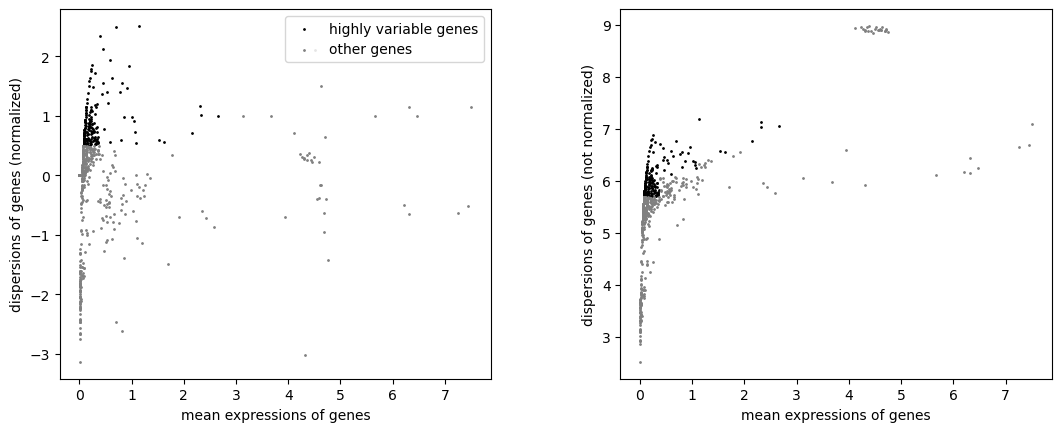

/home/jans/miniconda3/envs/py-infer/lib/python3.12/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


Nr. genes:  4191  ->  191
Nr. cells:  103160  ->  3638


In [32]:
# filter out highly variable genes - exclude perturbed genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)
adata = adata[:, adata.var.highly_variable | adata.var["gene_perturbed"]]

# Regress out:
#  'total_counts':    effects of total counts per cell 
#  'pct_counts_mt':   percentage of mitochondrial genes expressed. 
sc.pp.regress_out(adata, ['total_counts']) # Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed

# Scale the data to unit variance:
#  A: scanpy implementation
#sc.pp.scale(adata, zero_center=False, max_value=10)
#  B: adapted implementation for perturbations
scpi.adata.scale_counts(adata, max_value=None)

n_genes_after = adata.shape[1]
n_cells_after = adata.shape[0]
print("Nr. genes: ", n_genes, " -> ", n_genes_after)
print("Nr. cells: ", n_cells, " -> ", n_cells_after)

Check what count distribution looks like:

In [33]:
# print mean and variance of counts for a few genes
print(adata.X.mean(axis=1)[:10])
print(adata.X.var(axis=1)[:10])

# print([i for i in adata.var['mean'][0:10]])
# print([i for i in adata.var['std'][0:10]])
# print corresponding perturbation labels
print( [i for i in adata.obs['perturbation'][:10]])

# Check the expression of downregulated genes
scpi.adata.print_expression_mean_std(adata)

[-3.9468952e-02 -1.1001947e-01  8.0821587e-04  9.9861186e-09
 -4.6275977e-02 -8.2266994e-02 -4.9930593e-09 -1.4979177e-08
 -5.8884725e-02 -4.9930593e-09]
[1.2855102  3.2893414  0.9896529  0.9947645  1.396407   2.2754214
 0.99476457 0.9947643  1.648337   0.9947643 ]
['RIPK2', 'DSCC1', 'OXR1', 'non-targeting', 'STK3', 'FAM83A', 'non-targeting', 'non-targeting', 'RIPK2', 'non-targeting']

Perturbed Gene Expression:
Mean:  -7.030878653391184
Std:  7.601884737044947
Min:  -39.73506164550781
Max:  18.968366622924805
95% percentile:  -19.679874420166016  -  2.9409425258636475

Non-Target Gene Expression:
Mean:  0.04838929697588561
Std:  0.9514395531673208
Min:  -11.086400985717773
Max:  9.37711238861084
95% percentile:  -0.1767454832792282  -  0.21792921125888803


In [ ]:
plot_filename = "./plots/normalized.png"
scpi.adata.plot_perturb_vs_non(adata,all_non_pert=False, filename=plot_filename)

In [36]:
# write scanpy annotated data object to file
sc.write(results_file, adata)

# B. UMAP Visualization

In [ ]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [ ]:
pert_genes = adata.var_names[adata.var["gene_perturbed"]]

In [ ]:
sc.tl.umap(adata)
sc.pl.umap(adata)

In [ ]:
sc.pl.umap(adata, color = ['replicate','nperts','perturbation'])

## UMAP - only perturbed cells

In [ ]:
indices =adata.obs['gene_pert'] | adata.obs['non-targeting']
adata_pert = adata[indices,:].copy()
adata_pert

sc.pp.neighbors(adata_pert, n_neighbors=10, n_pcs=40)

In [ ]:
sc.tl.umap(adata_pert)
sc.pl.umap(adata_pert)

In [ ]:
sc.pl.umap(adata_pert, color = ['replicate','nperts','perturbation'])
sc.pl.umap(adata_pert, color = ['percent_ribo','ncounts','ngenes'])

In [ ]:
# Filtered by replicate
adata_sample = adata[adata.obs['replicate']=='sample_14',:].copy()
pert_genes = adata_sample.var_names[adata_sample.var["gene_perturbed"]]
sc.pp.neighbors(adata_sample, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_sample)
sc.pl.umap(adata_sample)

In [ ]:
sc.pl.umap(adata_sample, color = pert_genes)